Dependencies esterne a quelle di base di jupyter:
PySAL, geopandas, 

# Our project and data

Il nostro progetto mira a valutare la correlazione tra le principali "variabili" ambientali, sociali ed economiche nello sviluppo delle varie nazioni del mondo. 
Inoltre, si è posta maggior attenzione al caso dell'Italia cercando di prevedere il "futuro" delle diverse variabili nei prossimi 10 anni considerando l'andamento di queste dal 1990 al 2016.
Infine è stato tentato un raggruppamento tra stati con caratteristiche simili (nello stesso anno) sfruttando il K-Means Clustering (con $K\in[4,30]$ ).

Le variabili che abbiamo preso in considerazioni per ogni stato negli anni tra il 1990 e il 2016 sono:
- Variabili Sociali:
    * Aspettativa di vita (in anni)
    * Popolazione totale
- Variabili Economiche:
    * Debito pubblico (in percentuale del PIL)
    * Bilancio dello stato (in US\$)
    * PIL (in US\$)
    * PIL pro capite (in US\$)
    * Riserve economiche dello stato (compreso oro, in US\$) 
- Variabili Ambientali ed Energetiche:
    * Superficie del territorio dedicata all'agricoltura (in percentuale del territorio)
    * Territorio boschivo (in $\text{km}^2$)
    * Consumo elettrico (in kWh pro capite)
    * Importazioni di energia (in percentuale di utilizzo di energia totale)
    * Esportazioni di energia (in percentuale del totale di merce esportata)
    * Uso di energia (in equivalente di kg di petrolio pro capite)
    * Consumo di energie rinnovabili (in percentuale di energia totale consumata)
    * Produzione di energia elettrica rinnovabile (in percentuale di energia elettrica totale prodotta)
    * Emissioni di $\text{CO}_2$ (in migliaia di tonnellate)

Abbiamo scelto questi dati perchè, a parer nostro, rappresentano economicamente ogni paese e il rispettivo sviluppo di quest'ultimo.

## Dataset Description, Building and Cleaning

Per ciascuna delle variabili listate in precedenza è stato trovato il rispettivo dataset presso il [World Bank Open Data](https://data.worldbank.org/) (WBOD). Ciascuno dei singoli dataset della WBOD è strutturato per avere in ogni riga il nome, il codice della nazione e i valori della variabile dal 1960 al 2016. 
Ognuno di questi dataset è stato "ristrutturato" in modo da avere N $\times$ M righe (dove N è il numero di nazioni e M è il numero di anni) e 3 colonne. Le tre colonne saranno: Anno, Codice della Nazione e valore per l'anno in questione della variabile del dataset. 

Un esempio di questa trasformazione è data dalla seguente figura:

| Country Name |  Code  | 1960 | 1961 | ... | 2016 |
|:-------:|:------:|:----:|:----:|:---:|:----:|
|Italy	  |ITA|	ita_val1_1960|ita_val1_1961|...|ita_val1_2016|
|United States of America|USA|us_val1_1960|us_val1_1961|...	|us_val1_2016|
|China|CHN|chn_val1_1960|chn_val1_1961|...|chn_val1_2016|
|Japan|JPN|jpn_val1_1960|jpn_val1_1961|...|jpn_val1_2016|

diventa

| Code | Year |  Variabile1 |
|:----:|:----:|:-----------:|
| ITA  | 1960 |ita_val1_1960|
| ITA  | 1961 |ita_val1_1961|
| ...  | ...  |     ...     |
| ITA  | 2016 |ita_val1_2016|
| CHN  | 1960 |chn_val1_1960|
| CHN  | 1961 |chn_val1_1961|
| ...  | ...  |    ...      |
| CHN  | 2016 |chn_val1_2016|
| ...  | ...  |    ...      |

Una volta effettuata questa ristrutturazione per ogni dataset, viene costruito il dataset di progetto effettuando un join sul codice della nazione e l'anno ottenendo così il seguente dataframe:


| Code | Year |  Variabile1 |  Variabile2 | ... |  VariabileN |
|:----:|:----:|:-----------:|:-----------:|:---:|:-----------:|
| ITA  | 1960 |ita_val1_1960|ita_val2_1960| ... |ita_valN_1960|
| ITA  | 1961 |ita_val1_1961|ita_val2_1961| ... |ita_valN_1961|
| ...  | ...  |     ...     |     ...     | ... |     ...     |
| ITA  | 2016 |ita_val1_2016|ita_val2_2016| ... |ita_valN_2016|
| CHN  | 1960 |chn_val1_1960|chn_val2_1960| ... |chn_valN_1960|
| CHN  | 1961 |chn_val1_1961|chn_val2_1961| ... |chn_valN_1961|
| ...  | ...  |    ...      |    ...      | ... |    ...      |
| CHN  | 2016 |chn_val1_2016|chn_val2_2016| ... |chn_valN_2016|
| ...  | ...  |    ...      |    ...      | ... |    ...      |



Una volta effettuata la costruzione del dataset di progetto, è stata necessaria una ripulitura poichè molti campi erano assenti (e dunque valutati da pandas come NaN). Tale ripulitura è stata effettuata per singola variabile e per singola nazione facendo variare l'anno. Alla prima occorrenza del NaN per una variabile viene fatto un check:

<div style="text-align:center"><img src="./report_img_folder/nan_check.png"/></div>

Quindi la ripulitura consiste nel propagare i valori in avanti ponendo lo 0 all'inizio (1960) se tale variabile per una data nazione è pari a NaN. 

Un esempio è il seguente: supponiamo di avere la variabile Var1 e consideriamo solo l'Italia


| Code | Year |    Var1     |
|:----:|:----:|:-----------:|
| ITA  | 1960 |     NaN     |
| ITA  | 1961 |     NaN     |
| ITA  | 1962 |     NaN     |
| ITA  | 1963 |     43      |
| ITA  | 1964 |     45      |
| ITA  | 1965 |     NaN     |
| ITA  | 1966 |     NaN     |
| ITA  | 1967 |     61      |
| ITA  | 1968 |     NaN     |
| ITA  | 1969 |     65      |
| ITA  | 1970 |     70      |
| ...  | ...  |     ...     |
| ITA  | 2016 |     68      |

I vari NaN della colonna Var1 diventerebbero:

| Code | Year |    Var1     |
|:----:|:----:|:-----------:|
| ITA  | 1960 |      0      |
| ITA  | 1961 |      0      |
| ITA  | 1962 |      0      |
| ITA  | 1963 |     43      |
| ITA  | 1964 |     45      |
| ITA  | 1965 |     45      |
| ITA  | 1966 |     45      |
| ITA  | 1967 |     61      |
| ITA  | 1968 |     61      |
| ITA  | 1969 |     65      |
| ITA  | 1970 |     70      |
| ...  | ...  |     ...     |
| ITA  | 2016 |     68      |


Questa ripulitura è stata necessaria per permettere di non sbilanciare troppo la regressione lineare utilizzata per le predizioni delle variabili per l'Italia. Inoltre, avendo molti NaN (e quindi 0) nei primi anni, abbiamo deciso di selezionare gli anni dal 1990 al 2016 per avere dati più completi e veritieri (nonostante la propagazione dei valori).

Un'altra parte della ripulitura, invece, consisteva nel rimuovere le entry del dataset che non erano relative a una nazione ma a gruppi di nazioni o perfino il mondo intero. Dunque è stata fatta una "blacklist" con cui si escludono questi gruppi di nazioni (facilmente individuabile nel seguente codice).


In [161]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd



# Dataset location

datasetFolder="datasets/"
datasetFiles = {
    "Agricultural Land"                :"agriculturalLand.csv",
    "Debt"                             :"centralGovernmentDebt.csv",
    "CO2 Emissions"                    :"CO2Emissions.csv",
    "Account Balance"                  :"currentAccountBalance.csv",
    "Electric Consumption"             :"electricPowerConsumption.csv",
    "Energy Imports"                   :"energyImports.csv",
    "Energy Use"                       :"energyUse.csv",
    "Forest Area"                      :"forestArea.csv",
    "Fuel Exports"                     :"fuelExports.csv",
    "GDP"                              :"GDP.csv",
    "GDP Procapite"                    :"GDPProCapite.csv",
    "Life expectancy"                  :"lifeExpectancy.csv",
    "Population"                       :"Population.csv",
    "Renewable Electricity Consumption":"renewableElectricityConsumption.csv",
    "Renewable Electricity Output"     :"renewableElectricityOutput.csv",
    "Money Reserves"                   :"TotalReserves.csv"
}

# Entries to be excluded

ex = [
        #"China",
        #"United States",
        "World",
        "Arab World",
        "Central Europe and the Baltics",
        "Caribbean small states",
        "East Asia & Pacific (excluding high income)",
        "Early-demographic dividend",
        "East Asia & Pacific",
        "Europe & Central Asia (excluding high income)",
        "Europe & Central Asia",
        "Euro area",
        "European Union",
        "High income",
        "Heavily indebted poor countries (HIPC)",
        "IBRD only",
        "IDA & IBRD total",
        "IDA total",
        "IDA blend",
        "IDA only",
        "Not classified",
        "Latin America & Caribbean (excluding high income)",
        "Latin America & Caribbean",
        "Least developed countries: UN classification",
        "Low income",
        "Lower middle income",
        "Low & middle income",
        "Late-demographic dividend",
        "Middle East & North Africa",
        "Middle income",
        "Middle East & North Africa (excluding high income)",
        "North America",
        "OECD members",
        "Other small states",
        "Pre-demographic dividend",
        "Pacific island small states",
        "Post-demographic dividend",
        "Sub-Saharan Africa (excluding high income)",
        "Sub-Saharan Africa",
        "Sub-Saharan Africa (IDA & IBRD countries)"
        "Small states",
        "East Asia & Pacific (IDA & IBRD countries)",
        "Europe & Central Asia (IDA & IBRD countries)",
        "Latin America & the Caribbean (IDA & IBRD countries)",
        "Middle East & North Africa (IDA & IBRD countries)",
        "South Asia (IDA & IBRD)",
        "Upper middle income",
        "World",
        "Fragile and conflict affected situations",
        "South Asia",
        "Sub-Saharan Africa (IDA & IBRD countries)"
]

# Years of interest

interestInterval = (1990, 2016)
startingYear = 1960

# Dataframe building

dfList = []
for key, value in datasetFiles.items(): 
    tempDfList = []
    dataframe = pd.read_csv(datasetFolder+value, sep=',', header=2)
    
    # Each file considered starts from 1960. Each value equal to NaN for that year
    # is put to 0. Each following NaN for that dataset will take the closest previous
    # value different from NaN.
    # e.g.: NaN NaN NaN 1 2 3 NaN NaN 4
    # Supposing that the first NaN refers to 1960,
    # this row will turn first in:  0 NaN NaN 1 2 3 NaN NaN 4
    # and then to: 0 0 0 1 2 3 3 3 4
    dataframe[str(startingYear)].fillna(0, inplace=True)
    dataframe = dataframe.fillna(method='ffill', axis=1)
    
    
    # Filtering out
    dataframe = dataframe[~dataframe['Country Name'].isin(ex)]
    
    # For each file is created a new dataframe in which each row
    # is composed by Country Name, Value of interest of dataset (e.g. GDP), Year of that value
    # so each country appears once for each year of interest (in this case 27 times)
    for i in range (interestInterval[0], interestInterval[1]+1):
        temp_df = dataframe[["Country Code",str(i)]]
        temp_df.is_copy = False
        temp_df['Year'] = i
        # Renaming for Country Name and adding of column Year
        temp_df.columns=["Country", key, "Year"]
        tempDfList.append(temp_df)    
    # Each element of the dfList refers to a single "new" dataset.
    # Those datasets must be merged by column
    dfList.append(pd.concat(tempDfList))
    

# Merging of datasets by columns "Country" and "Year"
df = dfList[0]
for i in range(1, len(dfList)):
    df = pd.merge(df, dfList[i], on=["Country","Year"])
    

# Columns rearrangement to have Year and Country Name as first columns
cols = df.columns.tolist()
year_i = cols.index("Year")
cols.pop(year_i)
cols = ["Year"] + cols
df = df[cols]

# Conversion, when possible, to numeric values (instead of string)
df = df.apply(pd.to_numeric, errors='ignore')

df

,Year,Country,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
0,1990,ABW,11.111111,0.000000,1639.149,-1.581564e+08,0.000000,0.000000,0.000000,4.2,0.003947,0.000000e+00,0.000000,73.468000,62149.0,0.268747,0.000000,1.364300e+08
1,1990,AFG,58.266703,0.000000,2614.571,-1.433000e+08,0.000000,0.000000,0.000000,13500.0,13.224223,3.478788e+09,266.493042,49.856000,12249114.0,15.924532,67.730496,6.379257e+08
2,1990,AGO,46.044758,0.000000,5115.465,-2.355000e+08,51.760511,-387.018022,483.357394,609760.0,93.477680,1.002674e+10,823.792184,41.696000,12171441.0,72.255252,86.206897,0.000000e+00
3,1990,ALB,40.912409,0.000000,5515.168,-1.183000e+08,552.252185,7.965058,813.255696,7888.0,0.000000,2.101625e+09,639.463899,71.836000,3286542.0,25.518088,86.407767,0.000000e+00
4,1990,AND,48.936170,0.000000,407.037,0.000000e+00,0.000000,0.000000,0.000000,160.0,0.000000,1.029048e+09,18878.505969,0.000000,54509.0,14.273550,100.000000,0.000000e+00
5,1990,ARE,3.409091,0.000000,52009.061,0.000000e+00,8355.669953,-439.553112,10979.654054,2450.0,3.458279,5.070144e+10,27256.290943,71.541000,1860174.0,0.000000,0.000000,4.890565e+09
6,1990,ARG,46.612879,0.000000,112147.861,4.552000e+09,1299.552068,-5.109712,1407.386750,347930.0,7.800725,1.413524e+11,4318.774700,71.565000,32729739.0,8.922907,35.441466,6.222040e+09
7,1990,ARM,0.000000,0.000000,0.000,0.000000e+00,2722.597731,98.070500,2178.547354,3350.0,0.000000,2.256839e+09,637.855741,67.879000,3538165.0,2.118944,15.006755,0.000000e+00
8,1990,ASM,15.000000,0.000000,0.000,0.000000e+00,0.000000,0.000000,0.000000,183.9,0.000000,0.000000e+00,0.000000,0.000000,47038.0,0.000000,0.000000,0.000000e+00
9,1990,ATG,20.454545,0.000000,282.359,-3.098519e+07,0.000000,0.000000,1481.760705,103.0,0.000000,4.594691e+08,6889.004949,71.351000,66696.0,0.000000,0.000000,2.750000e+07


# Exploratory Analysis

## Descriptive Statistics

Abbiamo ricavato le variabili descrittive del dataset per quanto riguarda tutti gli anni e tutte le nazioni.
Ciò non è molto esplicativo e dunque è stato effettuato lo stesso fissando uno stato (Italia) e fissando un anno (2016).

### Global, all years, Descriptive Statistics

In [162]:
# Descriptive Statistics of all the dataset (containing each country of each year)

# (excluding country name and year columns)
df.iloc[:,2:].describe()

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
count,5886.000000,5886.000000,5.886000e+03,5.886000e+03,5886.000000,5886.000000,5886.000000,5.886000e+03,5886.000000,5.886000e+03,5886.000000,5886.000000,5.886000e+03,5886.000000,5886.000000,5.886000e+03
mean,35.997906,23.542956,1.220681e+05,-6.169706e+07,2415.053473,-23.535058,1700.055796,1.896494e+05,13.680439,2.151401e+11,10863.996184,64.574478,2.923454e+07,29.342055,28.537641,2.426538e+10
std,23.196161,64.679773,5.934112e+05,3.651643e+10,4454.337925,156.972494,2627.180991,7.427578e+05,26.388871,1.019841e+12,19076.894609,18.216478,1.184932e+08,30.859163,33.580963,1.475685e+11
min,0.000000,0.000000,0.000000e+00,-8.059620e+11,0.000000,-1942.003038,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,16.230414,0.000000,5.280480e+02,-6.042250e+08,0.000000,0.000000,104.182080,6.501250e+02,0.002136,1.716552e+09,657.315412,60.163000,6.103782e+05,2.200811,0.000000,3.420731e+07
50%,36.392091,0.000000,5.095297e+03,-2.848620e+07,520.254558,0.000000,654.962875,1.781050e+04,1.316173,9.201687e+09,2871.522297,70.192500,5.241082e+06,17.137026,12.426208,7.072211e+08
75%,54.801679,35.936099,4.841998e+04,0.000000e+00,3081.158110,40.272656,2272.092471,9.337000e+04,9.663587,6.686301e+10,12594.992247,75.147726,1.803786e+07,51.496533,53.274646,7.709480e+09
max,85.487373,1772.199043,1.029193e+07,4.205685e+11,54799.174708,100.000000,21959.436256,8.151356e+06,99.986485,1.862448e+13,192989.189527,85.417073,1.378665e+09,98.342602,100.000000,3.900039e+12


### Italian, all years, Descriptive Statistics

In [163]:
# Descriptive Statistics of Italy for each year

# (excluding country name and year columns)
df[df['Country']=="ITA"].iloc[:,2:].describe()

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
count,27.000000,27.000000,27.000000,2.700000e+01,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01,27.000000,27.000000,2.700000e+01,27.000000,27.000000,2.700000e+01
mean,50.385283,74.617040,417764.197333,-4.508223e+09,5117.063608,81.240683,2839.977386,85420.555556,2.773323,1.632865e+12,27994.618071,80.215628,5.805161e+07,8.416796,23.266277,9.035337e+10
std,3.511254,14.957842,46488.826608,3.342817e+10,529.552355,2.617376,244.307374,5430.299314,1.228297,4.500617e+11,7191.318576,1.910193,1.417669e+06,4.557474,8.856508,4.263700e+10
min,44.009655,0.000000,320411.459000,-7.301756e+10,4144.907442,75.001304,2414.484002,75900.000000,1.111574,1.061445e+12,18676.952579,76.970732,5.671924e+07,3.781463,15.480725,4.530190e+10
25%,47.841844,77.720025,403476.343000,-2.652613e+10,4724.992701,80.949856,2619.665223,80963.500000,1.846888,1.240580e+12,21831.864369,78.673171,5.687533e+07,4.835442,17.839693,5.671943e+10
50%,50.679948,77.720025,425830.375000,-3.380408e+09,5159.183655,81.728602,2834.402946,86030.000000,2.304151,1.569650e+12,27387.226315,80.229268,5.731320e+07,5.935949,19.793254,7.225431e+10
75%,52.937676,77.720025,450456.113500,2.074389e+10,5527.253726,83.311844,3028.944080,90011.000000,3.759572,2.098941e+12,35092.200188,81.836585,5.918639e+07,12.222346,24.889648,1.310447e+11
max,57.257489,77.720025,473970.751000,5.045576e+10,5833.467297,84.423070,3214.674121,92970.000000,4.792215,2.390729e+12,40640.183858,83.090244,6.078914e+07,17.090359,43.391606,1.816703e+11


### Global, 2016, Descriptive Statistics

In [164]:
# Descriptive Statistics of each country for 2016

# (excluding country name and year columns)
df[df['Year']==2016].iloc[:,2:].describe()

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
count,218.000000,218.000000,2.180000e+02,2.180000e+02,218.000000,218.000000,218.000000,2.180000e+02,218.000000,2.180000e+02,218.000000,218.000000,2.180000e+02,218.000000,218.000000,2.180000e+02
mean,36.639678,28.799921,1.565752e+05,7.836438e+08,2763.115884,-15.880088,1804.814201,1.872116e+05,13.132220,3.474188e+11,15661.145692,69.309949,3.421866e+07,28.513153,29.998014,5.143673e+10
std,22.869872,43.955540,8.091064e+05,4.417583e+10,5195.007494,125.527725,2736.359611,7.413344e+05,25.001088,1.555038e+12,24229.026297,16.280322,1.341569e+08,28.242114,32.462941,2.384557e+11
min,0.000000,0.000000,0.000000e+00,-4.516920e+11,0.000000,-1058.120023,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.109700e+04,0.000000,0.000000,0.000000e+00
25%,17.506643,0.000000,9.515865e+02,-1.507561e+09,0.000000,0.000000,171.484996,8.750000e+02,0.030800,4.380594e+09,1710.863902,66.158000,7.961420e+05,4.160136,0.586800,1.961142e+08
50%,36.161394,0.000000,7.895051e+03,-1.656431e+08,729.938620,0.000000,774.824232,1.931000e+04,1.687443,2.109799e+10,5350.372143,73.492500,6.221590e+06,18.323583,16.489641,2.215818e+09
75%,54.550445,50.810530,5.684033e+04,1.931977e+07,3705.781951,41.390958,2317.819391,9.410500e+04,10.573800,1.573998e+11,17451.808619,77.423165,2.363174e+07,45.164590,53.738328,2.294852e+10
max,82.559707,283.745256,1.029193e+07,2.868423e+11,53832.479092,100.000000,18562.666909,8.149305e+06,99.986485,1.862448e+13,168146.015281,85.417073,1.378665e+09,95.817700,100.000000,3.097658e+12


## Correlations

Per capire quanto incidono delle variabili rispetto alle altre è stata usata la matrice delle correlazioni. Una volta estratta facilmente con Pandas essa è stata rappresentata con una heatmap

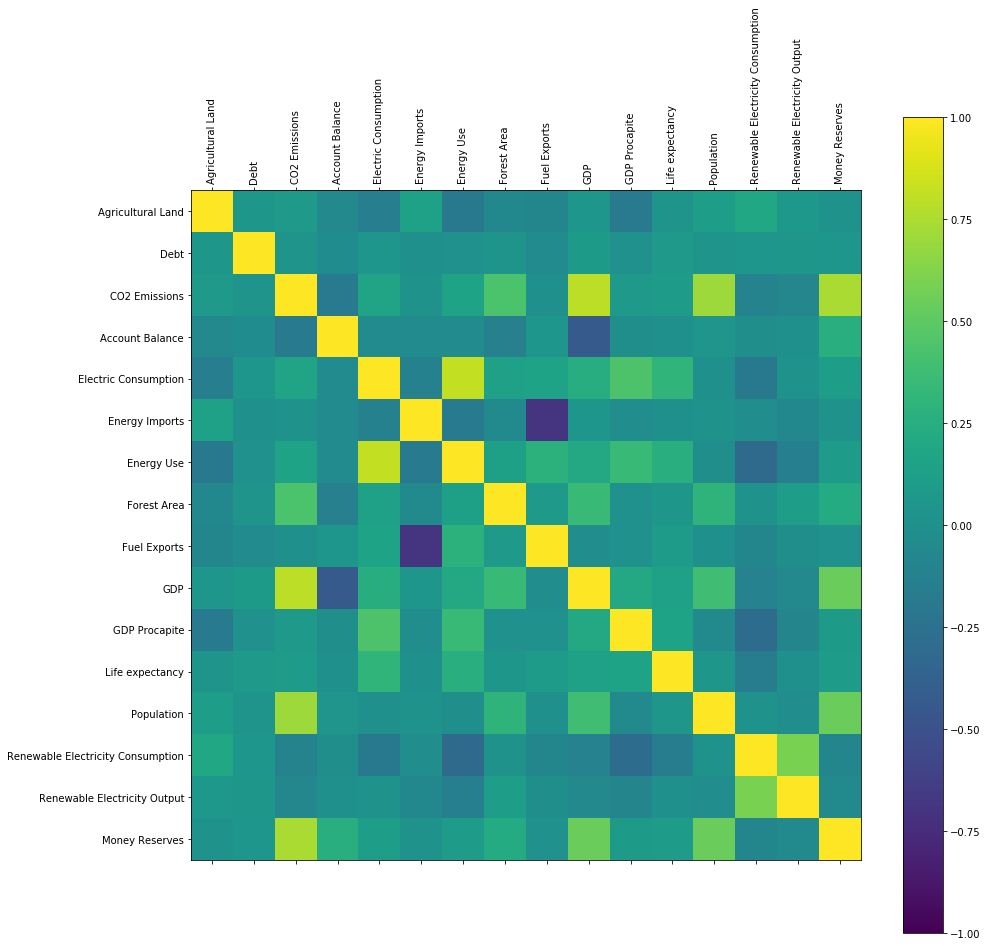

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation matrix
corr_matrix = df.iloc[:,2:].corr()

names = list(corr_matrix.columns)
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)
plt.show()



## Most Correlated Variables

Come è possibile visualizzare nel seguito, le 4 variabili più correlate sono:

1. Consumo di energia elettrica (in percentuale del consumo totale) - Consumo di energia totale
3. Emissioni di $\text{CO}_2$    - PIL
2. Emissioni di $\text{CO}_2$    - Riserve economiche dello stato
4. Emissioni di $\text{CO}_2$    - Popolazione

Seguono ora delle possibili motivazioni, essenzialmente esse sono delle congetture da dover confermare (o smentire) con ulteriori dati.

Per quanto concerne il primo elemento della lista, si può pensare che sia dovuto al fatto che lo sviluppo energetico sia stato svolto negli ultimi 60 anni nell'ottica di energie elettriche. Col passare degli anni e con lo sviluppo di apparecchi elettronici sono aumentati i consumi di energia. Energia che è cresciuta più dal punto di vista elettrico per soddisfare la necessità di funzionamento dei dispositivi realizzati. Dunque avere un basso consumo energetico, allo stato attuale, significa non essere competitivi dal punto di vista economico. Non essere competitivi dal punto di vista economico porta i cittadini delle nazioni più povere a non potersi permettere apparecchi sofisticati come l'elettronica di consumo. Dunque l'energia consumata in quelle nazioni sarà principalmente su base di combustibili fossili per il riscaldamento o la mobilità.

Per quanto riguarda il secondo punto della lista c'era da aspettarselo. Una popolazione economicamente sviluppata è sicuramente strettamente industrializzata. Un'economia florida porta ad avere un buon PIL e l'esportazioni merci prodotte da industrie influiscono al crescere del PIL (basti pensare a USA e Cina). Una grande industrializzazione porta a grandi emissioni di $\text{CO}_2$ ma soprattutto un grosso PIL porta benessere ai cittadini che possono permettersi il lusso di consumare più energia (automobili, mezzi, riscaldamento, ...)

Il terzo punto è strettamente correlato al secondo. Il discorso è analogo, solitamente una nazione ricca ha un buon PIL. Dunque il discorso del secondo punto rimane anche qui, una nazione ricca porta ad alti consumi energetici.

Per il quarto punto, infine si può osservare che aumentando la popolazione è normale riscontrare delle più alte emissioni di $\text{CO}_2$. Sia per industrie ma soprattutto come GAS di scarico di automobili, mezzi pubblici e riscaldamento delle abitazioni.


Electric Consumption  Energy Use       0.817586
CO2 Emissions         GDP              0.804575
Money Reserves        CO2 Emissions    0.744200
CO2 Emissions         Population       0.706116
dtype: float64


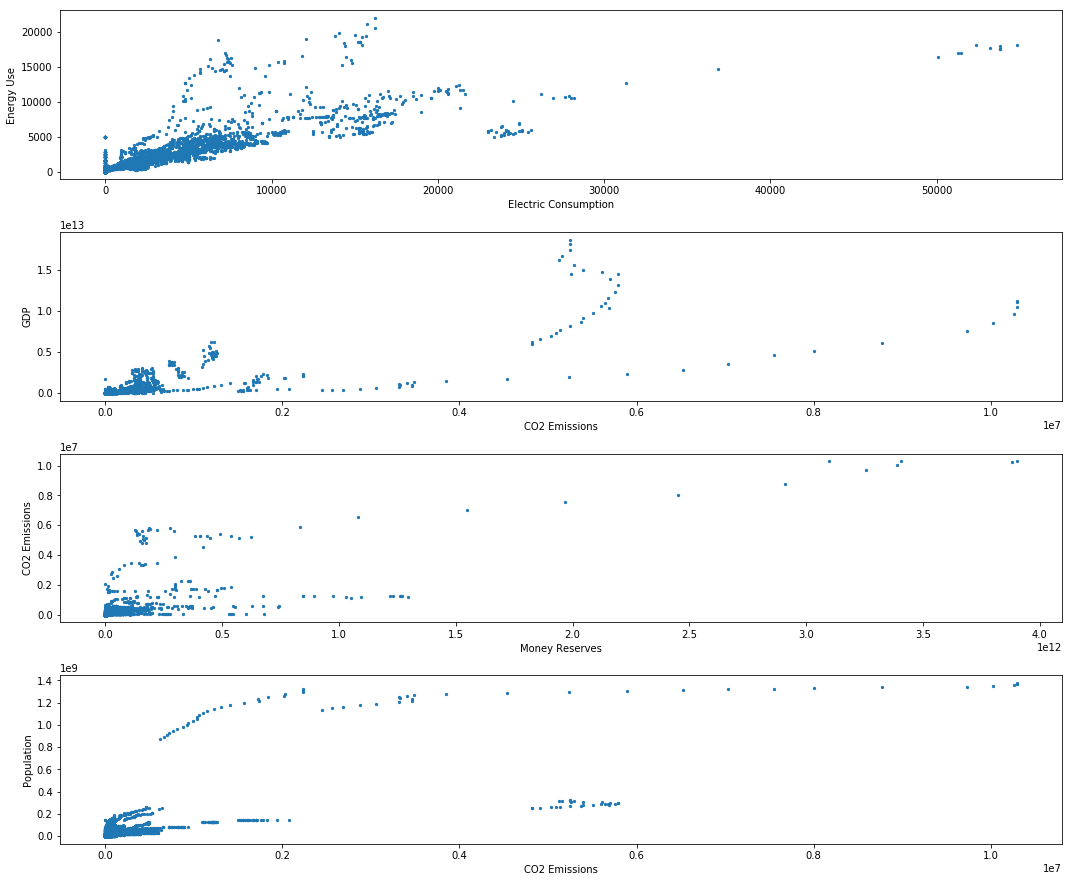

In [166]:
# N most correlated variables

N = 4

abs_c_matrix = corr_matrix.abs()
series = abs_c_matrix.unstack()
sorted_series = series.sort_values(kind="quicksort")
sorted_series = sorted_series.iloc[::-1]

sorted_series = sorted_series[sorted_series.shift(-1) != sorted_series]
sorted_series = sorted_series[sorted_series < 1][0:N]
print(sorted_series)

plt.rcParams['figure.figsize'] = (15,15)
indexes = list(sorted_series.index)
for i in range(1,N+1):
    plt.subplot(5, 1, i)
    plt.scatter(df[indexes[i-1][0]],df[indexes[i-1][1]], marker='o', s=5);
    plt.xlabel(indexes[i-1][0])
    plt.ylabel(indexes[i-1][1])
    
plt.tight_layout()
plt.show()

# Supervised Learning

Come accennato nell'introduzione, il Supervised Learning in questo progetto è stato utilizzato per la predizione delle variabili per l'Italia sfruttando i dati dal 1990 al 2016. Tali predizioni sono state effettuate fino al 2026.

Il modello scelto per queste predizioni è il modello della regressione lineare.  

## Linear Regression

La prima cosa da fare, per effettuare la regressione lineare, è calcolare la matrice $X$ delle osservazioni. Questa è stata "costruita" selezionando ogni riga del dataset il cui codice della nazione è "ITA" (filtrando, dopo la selezione, la colonna delle nazioni e degli anni poichè non incidono con l'andamento delle variabili). L'ultimo passaggio è la rimozione della riga $\hat{X}_{2016}$ relativa al 2016 (che verrà poi usata come input).

Una volta filtrata e costituita la matrice $X$ va costituita la matrice $Y$ delle variabili dipendenti. Tale matrice è ottenuta dalla matrice $X$ come segue: 

\begin{equation*}
 Y_i = {
\begin{cases}
    X_{i+1},& \text{if } i\leq 2014\\
    \hat{X}_{2016},& \text{if } i = 2015\\
\end{cases}
}
\end{equation*}
Dove $Y_i$ è l'i-esima riga della matrice $Y$ e $X_j$ è la j-sima riga della matrice $X$.

Tale assunzione implica che le variabili dell'anno $i$ hanno come output le variabili dell'anno $i+1$. 

Una volta costruite le matrici $X$ e $Y$ viene calcolata la matrice delle $\beta$ per il calcolo delle predizioni:

\begin{equation*}
\beta = {(X^T X)}^{-1}X^T Y
\end{equation*}

Una volta calcolato $\beta$ è possibile calcolare l'output $\hat{y}$ rispetto a un input $\hat{x}$ come segue:

\begin{equation*}
\hat{y} = \hat{x}\beta
\end{equation*}

Dunque per la predizione degli anni successivi il procedimento è il seguente ripetuto un numero di volte pare agli anni che si vogliono predire, in questo caso 10 volte:

1. Selezione del nuovo input $\hat{x}$ pari all'ultima riga di $Y$
2. Calcolo dell'output $\hat{y}$ relativo a $\hat{x}$
3. Inserimento di $\hat{x}$ come ultimo elemento di $X$ e inserimento di $\hat{y}$ come ultimo elemento di $Y$
4. Ricalcolo di $\beta$ usando le nuove $X$ e $Y$

In [170]:
import numpy as np
from numpy.linalg import inv

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# LINEAR REGRESSION

country = "ITA"
target_df = df.loc[df['Country']==country]

# Excluding country name
target_df = target_df.drop(df.columns[[1]], axis=1)



class LinearRegression:
    def __init__(self):
        self.beta = None
    
    def train(self, X, y):
        X = self._x_format(X)     
        # beta = (X^T * X)^(-1) * X^T * y
        self.beta = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), y)
    
    def predict(self, X_input):
        x_input = self._x_format(X_input)
        # result = x_input * beta
        return np.dot(x_input, self.beta)
    
    def _x_format(self, X):
        X = np.c_[ np.ones(X.shape[0]), X]
        return X

def dataPreprocessing(df):  
    # Ignoring year column
    df = df.drop(df.columns[[0]], axis=1)
    # Scaling
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns.values)
    
    # x_input will be the first input of our linear regression
    x_input = pd.DataFrame(df.iloc[-1])
    
    y = df.iloc[1:]
    X = df.iloc[:df.shape[0]-1]

    # data formatting as matrix
    x_input = x_input.as_matrix().T
    y = y.as_matrix()
    X = X.as_matrix()
    
    return X,y,x_input,scaler

# Prediction trial for 10 years
pred_years = 10
for i in range(1, pred_years+1):
    X,y,x_input,scal = dataPreprocessing(target_df)
    LR = LinearRegression()
    LR.train(X,y)
    # LR's beta in this case has dimension 17x16: 
    # 17 is the number of input variable (1 for bias)
    # 16 is the number of output variable
    y_hat = scal.inverse_transform(LR.predict(x_input))
    
    # Rebuilding of DataFrame, reinserting the Year at the end
    columns = list(df.columns)
    columns.remove("Country")
    columns.remove("Year")
    result = pd.DataFrame(data=y_hat)
    result.columns = columns
    result.insert(loc=0, column="Year", value=interestInterval[1]+i)

    target_df = pd.concat([target_df, result])
    
target_df.set_index('Year', inplace=True)
linear_df = target_df
linear_df

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
Year,,,,,,,,,,,,,,,,
1990,57.257489,0.000000,417550.289000,-1.643777e+10,4144.907442,82.727968,2583.888077,75900.000000,2.289327,1.177326e+12,20757.088678,76.970732,5.671924e+07,3.781463,16.376022,8.859544e+10
1991,54.585019,71.659463,423894.199000,-2.430156e+10,4224.740106,82.634121,2645.673237,76679.000000,2.304151,1.242109e+12,21884.104371,77.019512,5.675852e+07,4.669413,20.846513,7.225431e+10
1992,54.326612,77.720025,420535.227000,-2.927916e+10,4310.537968,81.736186,2627.340008,77458.000000,2.211071,1.315807e+12,23166.804063,77.419512,5.679709e+07,4.839463,20.553919,4.986159e+10
1993,54.095406,77.720025,411917.777000,7.732703e+09,4303.645312,80.938751,2611.990438,78237.000000,2.174555,1.061445e+12,18676.952579,77.721951,5.683182e+07,4.771495,20.579763,5.358981e+10
1994,53.388188,77.720025,407378.031000,1.319967e+10,4439.319253,79.870484,2578.465978,79016.000000,1.593084,1.095591e+12,19273.844170,77.921951,5.684340e+07,5.248022,21.089447,5.781713e+10
1995,52.133555,77.720025,430483.798000,2.509613e+10,4597.892598,81.512308,2799.375762,79795.000000,1.262211,1.170787e+12,20596.388576,78.170732,5.684430e+07,4.462278,17.466002,6.069011e+10
1996,52.187957,77.720025,425830.375000,3.997360e+10,4658.700157,80.960961,2796.154736,80574.000000,1.237706,1.308929e+12,23020.099940,78.521951,5.686028e+07,4.748914,19.308014,7.056644e+10
1997,52.174357,77.720025,430487.465000,3.227669e+10,4791.285246,81.145993,2834.402946,81353.000000,1.434947,1.239051e+12,21779.624367,78.824390,5.689037e+07,4.831420,18.743003,7.508649e+10
1998,52.646969,77.720025,440153.677000,2.010713e+10,4955.721944,81.728602,2912.947365,82132.000000,1.111574,1.266309e+12,22252.358086,78.975610,5.690674e+07,4.757625,18.322525,5.387970e+10


## Dataframe columns plots (Italy: 1990 - 2016)

Semplice visualizzazione delle variabili relative all'italia tra gli anni 1990 - 2016.

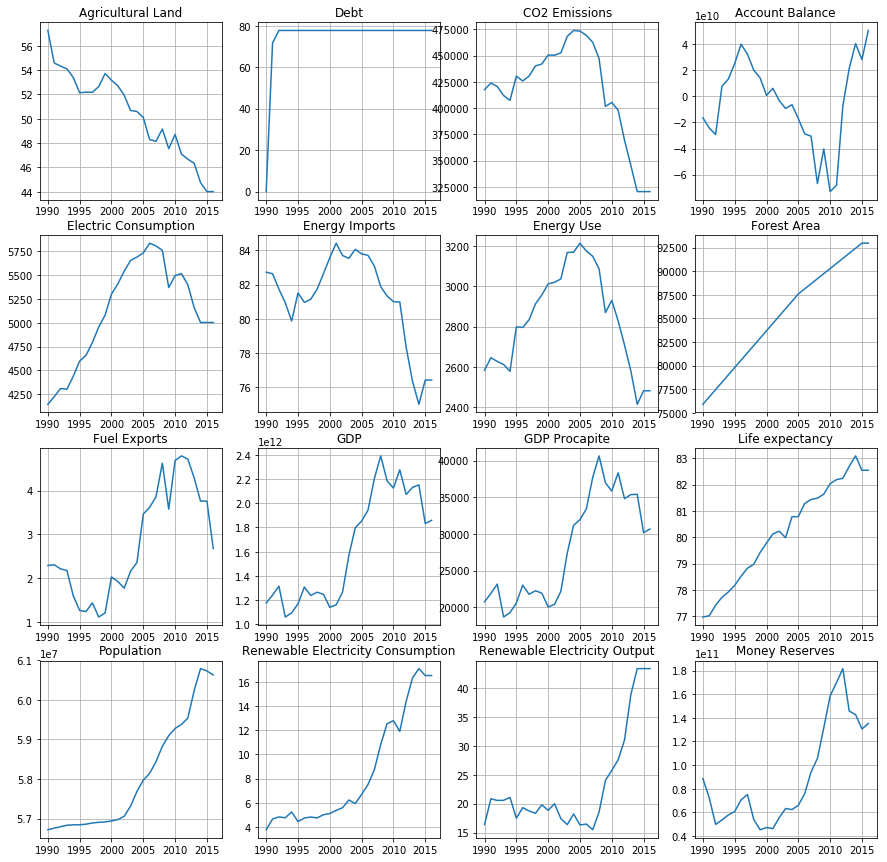

In [172]:
target_df = linear_df
fig = plt.figure(figsize=(15,15))

pre_regression = target_df.loc[interestInterval[0]:interestInterval[1]]

i = 1
for column in pre_regression:
    ax = fig.add_subplot(4,4,i)
    ax.set_title(column)
    ax.grid()
    ax.plot(pre_regression[column])
    i = i+1

### Italian GDP Example

Nell'immediato seguito vengono mostrate le predizioni per gli anni 2017-2026 relative all'andamento del PIL

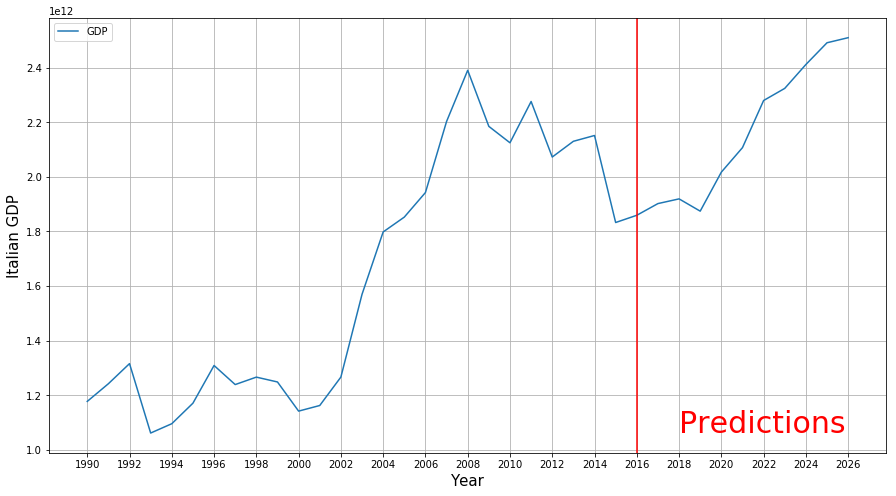

In [175]:
target_df = linear_df
# Var prediction plot example

import matplotlib.pyplot as plt
tar_var = "GDP" 

single_var_df = target_df[[tar_var]]

single_var_df.plot(x=target_df.index, y=tar_var, style='-', figsize=(15,8))
plt.xticks(np.arange(min(target_df.index), max(target_df.index)+1, 2.0))
plt.grid()
plt.ylabel("Italian " + tar_var, fontsize = 15)
plt.xlabel("Year", fontsize = 15)

# We have data until 2016

xcoord = interestInterval[1]
plt.axvline(x=xcoord, color="red")

plt.text(2018, target_df[[tar_var]].min(), "Predictions", color="red", fontsize=30)

plt.show()


# Unsupervised Learning

Per quanto riguarda l'Unsupervised Learning, ciò che abbiamo fatto consiste nel valutare quali sono le nazioni simili in un dato anno (2016 in questo caso). Abbiamo operato innanzitutto realizzando la Principal Component Analysis e selezionando le due principali componenti per poter vedere visivamente le componenti su uno scree-plot. Ci siamo resi conto, però, che l'explaine variance ratio era troppo bassa per sole due componenti e quindi abbiamo aumentato il numero (verrà spiegato meglio nel seguito).

Una volta effettuata la PCA è stato effettuato il K-Means Clustering sul risultato della PCA. Il K-Means Clustering è stato effettuato per $K\in[4,30]$. Infine è stato scelto il clustering con il Silhouette Value più alto ed è stato mostrato su uno shapefile del mondo. 

## Principal Component Analysis

La Principal Component Analysis è uno strumento importantissimo che permette di ottenere, tramite trasformazioni ortogonali del dataset, delle variabili incorrelate tra loro. Ciò è utile per esaminare quali sono le componenti che portano più informazione al dataset rispetto alle altre.

Prima di iniziare è stata formattata una copia del dataset eliminando la colonna degli anni e utilizzando la colonna del codice delle nazioni come indice del dataframe.
Per avere una PCA più accurata è stato fatto uno scaling e un fitting dei dati preliminare. Una volta effettuato ciò, è stata eseguita la PCA e sono state prese le prime due componenti per poter visualizzare lo scree-plot.

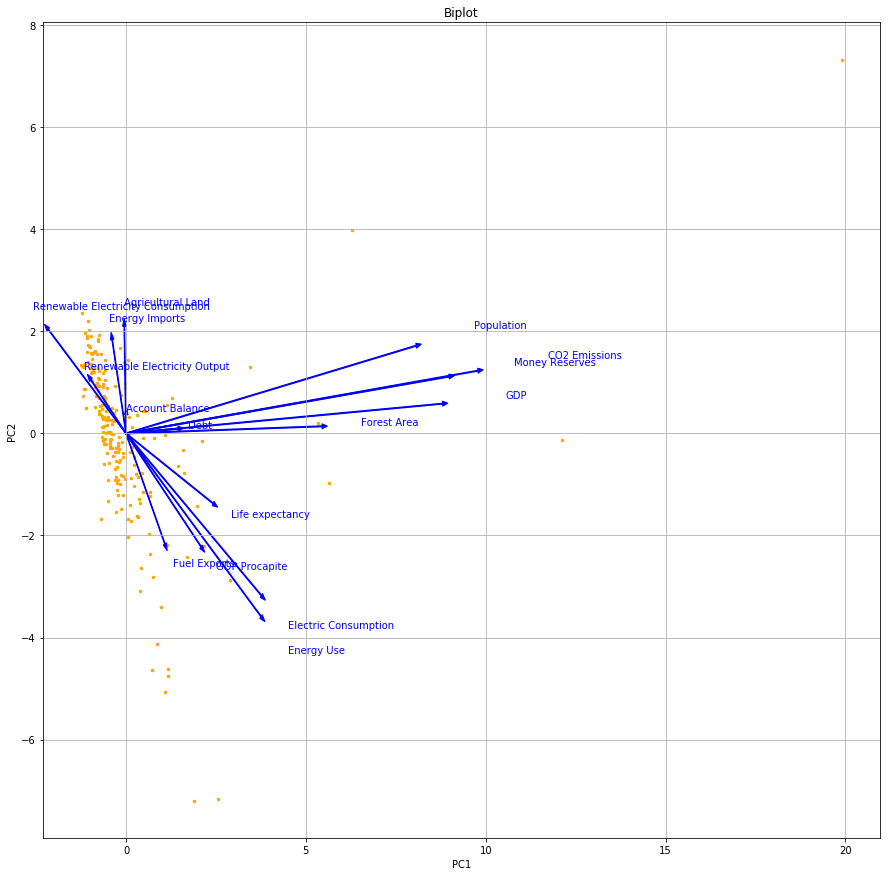

In [176]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

interest_year = 2016
target_df = df.loc[df['Year']==interest_year]

target_df.set_index('Country', inplace=True)

# Excluding year column
target_df = target_df.drop(df.columns[[0]], axis=1)

# Scaling
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(target_df), columns=target_df.columns.values, index=target_df.index)

# Number of components (in biplot I will choose just the principal 2 components)
n = target_df.shape[1] 

# Initialization
pca = decomposition.PCA(n_components = n)
pca.fit(scaled_df)

# We take just two components
xvector = pca.components_[0]
yvector = pca.components_[1]

# Projection on the new space
data_transformed = pca.transform(scaled_df)
data_transformed = pd.DataFrame(data_transformed, index=scaled_df.index)

# I take just two columns (two components)
# xs and ys are the projection on the two PCs
xs = data_transformed.iloc[:,0]
ys = data_transformed.iloc[:,1]

## Plot
# Points plotting
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Biplot")
ax.scatter(xs, ys, s=6, c="orange")

# Vector plotting
for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='b', width=0.02, head_width=0.1)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(target_df.columns.values)[i], color='b')

# Annotation plotting
#index = list(pd.DataFrame(data_transformed, index=target_df.index).index)
#for i, txt in enumerate(index):
#    ax.annotate(txt, (xs[i],ys[i]))

plt.grid()
plt.show()



### Explained Variance

Una volta visualizzato lo scree-plot, sono state analizzati i contributi che le singole componenti forniscono.
Tale analisi è stata effettuata visualizzando gli autovalori della matrice prodotta dalla PCA e visualizzando la varianza cumulativa con l'aumento delle componenti. Visualizzando questi due grafici ci siamo resi conto che le due componenti usate per lo scree-plot non sono sufficienti per avere un clustering significativo.

Per questa ragione abbiamo effettuato una selezione (scegliendo comunque le componenti che forniscono più varianza) del numero di componenti minima per avere un valore di varianza comulativa superiore al 80%.

Il risultato di questa selezione è mostrata nel seguito.

Number of components to have a cumulative variance ratio > 0.8 is: 8
Explained variance ratio: 83.0732%


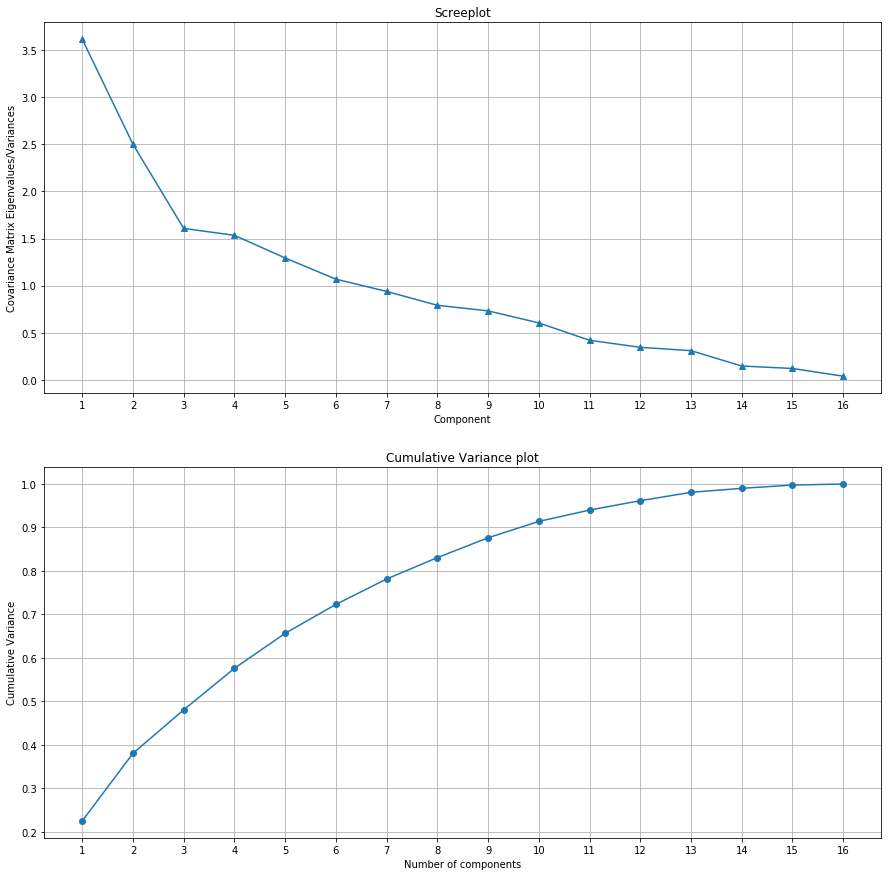

In [177]:
plt.rcParams['figure.figsize'] = (15,15)

# Variance explained:

# Variance for each column
variances = pca.explained_variance_
# Cumulative variance ratio
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

# Screeplot
plt.subplot(2, 1, 1)
plt.title("Screeplot")
plt.ylabel('Covariance Matrix Eigenvalues/Variances')
plt.xlabel('Component')
plt.plot(pd.Series(variances, index=range(1,n+1)), marker="^", linestyle="-")
plt.xticks(np.arange(1, n+1, 1.0))
plt.grid()

# Cumulative Variance Plot
plt.subplot(2, 1, 2)
plt.title("Cumulative Variance plot")
plt.ylabel('Cumulative Variance')
plt.xlabel('Number of components')
plt.plot(pd.Series(cumulative_variance_ratios, index=range(1,n+1)), marker="o", linestyle="-")
plt.xticks(np.arange(1, n+1, 1.0))
plt.grid()

# Number of components to have a cumulative variance ration > 0.7
ratio_threshold = 0.8
n_examined = np.argmax(cumulative_variance_ratios > ratio_threshold) + 1

explained_variance_ratio = sum(pca.explained_variance_ratio_[0:n_examined])
print("Number of components to have a cumulative variance ratio > "+str(ratio_threshold)+" is: "+str(n_examined))
print("Explained variance ratio: {:1.4f}%".format(explained_variance_ratio*100))

## K-Means Clustering

Una volta terminata la PCA e una volta scelto il numero $N$ di componenti ottimale per avere una varianza cumulativa significativa, è stato effettuato il K-Means Clustering. 

Il K-Means Clustering è stato effettuato diverse volte ($K\in [4,30]$) per selezionare quella $\hat{K}$ che massimizza la silhouette del clustering.

Il clustering sarà rappresentato con un dataframe contenente 1 sola colonna (l'intero rappresentante il numero del cluster per la data nazione) e come indice i codici delle varie nazioni. 

Una volta costituiti tutti i clustering e selezionato il "migliore", è stato visualizzato sul planisfero.

In [178]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


# First 2 Principal components DataFrame
PCA2 = data_transformed.iloc[:,:n_examined]

# Best silhouette and clustering initialization
best_silhouette = 0
best_clustering = None

# Random initial state
seed = 500

# Clustering several times to search for the best silhouette
for n_cluster in range(4,30):
    
    # random_state is the seed to have always the same starting points
    kmeans = KMeans(n_clusters=n_cluster, random_state=seed).fit(PCA2)
    cluster_labels = kmeans.predict(PCA2)
    
    # Silhouette avg computing (Silhouette of the clustering)
    silhouette_avg = silhouette_score(PCA2, cluster_labels)
    # If I found a better silhouette, I change the previous one 
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_clustering = cluster_labels
    
# The best number of cluster is the highest (numeric) label + 1 (since the labels start from 0)
best_n_clusters = max(best_clustering)+1

print("Best silhouette is for K = "+ str(best_n_clusters))
print("The best silhouette values (for K = " + str(best_n_clusters)+") is: "+str(best_silhouette))
# Printing of cluster colors for each country

cluster_column_name = "Cluster"
clusters = pd.DataFrame(best_clustering, index = target_df.index, columns = [cluster_column_name])
clusters = clusters.sort_values(by=cluster_column_name)


clusters

Best silhouette is for K = 9
The best silhouette values (for K = 9) is: 0.24739268208648207


,Cluster
Country,
ZWE,0
HRV,0
HND,0
SDN,0
GTM,0
SLE,0
SLV,0
GNB,0
GIN,0


### Visualizzazione del clustering

La visualizzazione del clustering, non potendola fare su un piano (dato il numero di componenti necessarie per avere un clustering utile), è stata fatta su un planisfero. 

La rappresentazione è stata fatta per mezzo della libreria geopandas. Questa permette l'importazione di uno shapefile in un dataframe. Le caratteristiche principali dello shapefile sono il campo "geometry" (contenente la geometry di ogni nazione) e il campo "ADM0_A3" contenente il codice della nazione per ogni campo geometry.
Una volta importato, il nuovo dataframe è stato modificato per utilizzare il codice della nazione come indice.
Dunque, per come era stato formattato il dataset di output del clustering, è stato effettuato un join su questi due dataframe (sugli indici) in modo da ottenere un dataset contenente 2 colonne: "geometry" e "Cluster" (il numero del cluster di ogni nazione).

A questo punto è stato visualizzato lo shapefile con le nazioni colorate sulla base della colonna "Cluster" e indicizzate sul codice della nazione.

OSS: Viene mostrata anche una legenda dalla dubbia utilità. Basta valutare il colore delle nazioni (e non quanto un colore sia vicino all'altro).

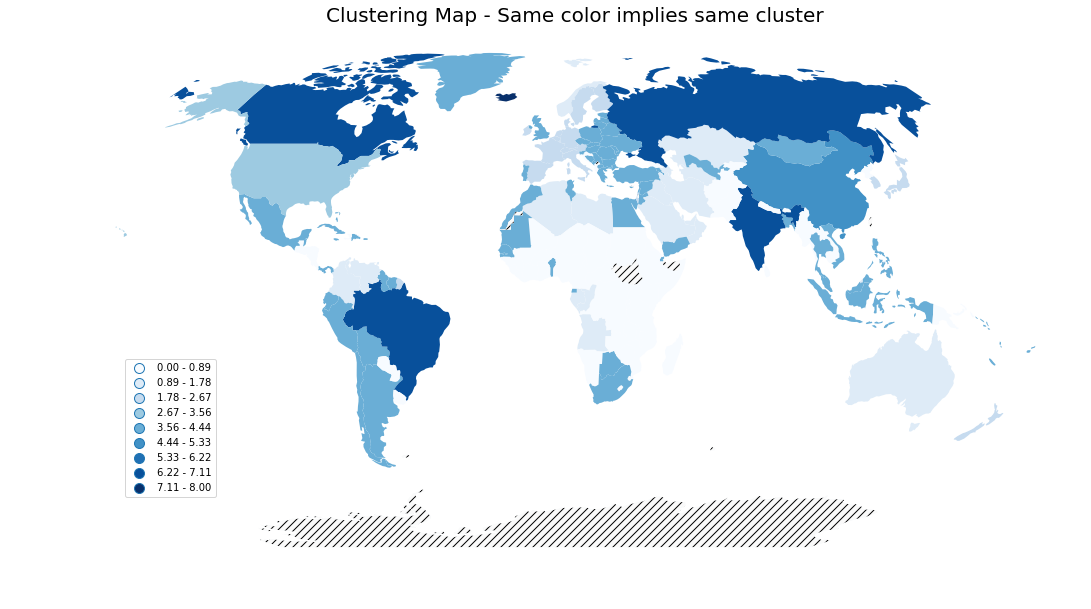

In [179]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

shapefile = os.path.expanduser('shapefile/ne_110m_admin_0_countries.shp')
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

figsize = (20,10)
col = "Cluster"
title = "Clustering Map - Same color implies same cluster"

gdf = gdf.set_index('ADM0_A3')
merged = gdf.merge(clusters, how='outer', left_index=True, right_index=True)
ax = merged.plot(column=col, cmap='Blues', figsize=figsize, k=best_n_clusters, legend=True, scheme="equal_interval")

merged[merged.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///')

ax.set_title(title, fontdict={'fontsize': 20}, loc='center')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.get_figure();

La mappa precedente mostra dei risultati interessanti. Il più significativo sta nella Cina e nell'Islanda: due nazioni uniche nel loro genere (rispettivamente sono due cluster con un solo elemento).
Ulteriori osservazioni verranno mostrate nelle considerazioni finali di questo documento.

## Cluster Silhouette

Infine per completezza è stata mostrata la silhouette del clustering migliore. 
La silhouette $SIL$ del clustering è definita come segue:

\begin{equation*}
 SIL = \frac{1}{M}\sum^M_{i=1}s(i)
\end{equation*}

\begin{equation*}
 s(i) = \frac{b_i - a_i}{max\{a_i, b_i\}}
\end{equation*}

Dove:
* $M$ è il numero di entry del dataset (del clustering)
* $SIL$ è la silhouette del clustering
* $s(i)$ è la silhouette del singolo punto $x_i$ del dataset
* $b(i)$ è la più piccola delle distanze medie tra $x_i$ e ciascun cluster (diverso da quello in cui è $x_i$) : $b(i) = min_{C\neq C_i} \frac{1}{|C|}\sum_{x_j \in C}d(x_i,x_j)$
* $a(i)$ è la distanza media tra $x_i$ e ciascun elemento del cluster in cui si trova

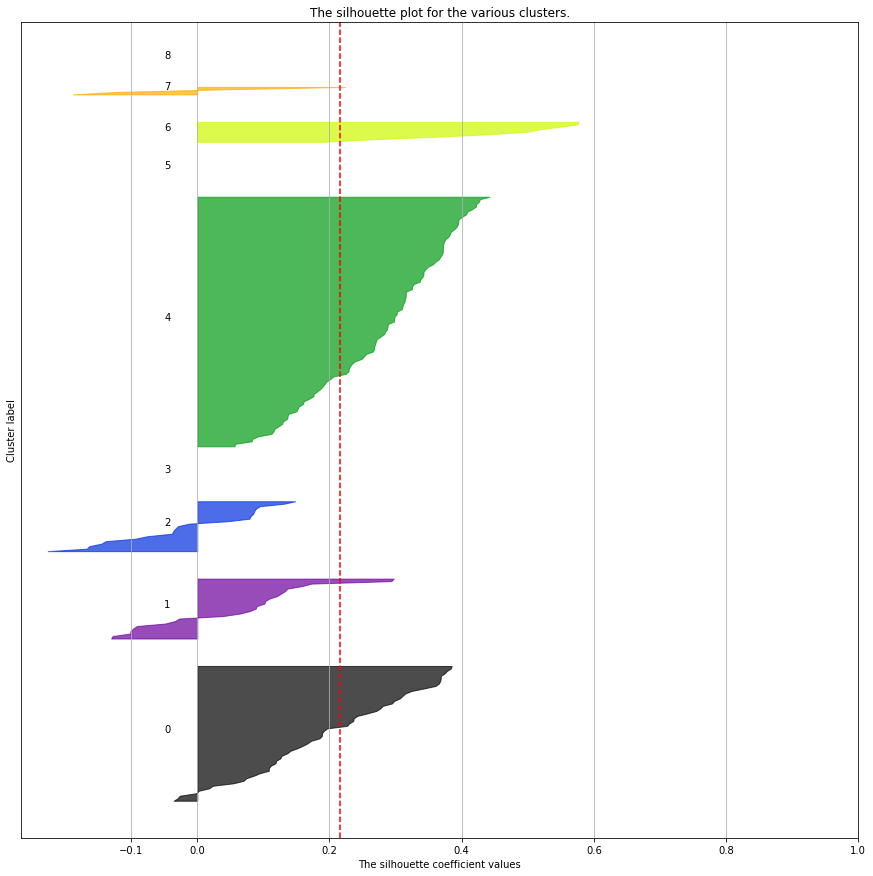

In [180]:
import matplotlib.cm as cm
sample_silhouette_values = silhouette_samples(data_transformed, best_clustering)


# Number of clusters with best silhouette
n_clusters = best_n_clusters
y_lower = 0

for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[best_clustering == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

# Setting of the ticks on the plot
plt.yticks([])  
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);
plt.grid()

## Final consideratons

In questo studio/progetto sono stati trattati diversi aspetti dei dati.

In primis abbiamo avuto modo di notare come alcune variabili incidono sulle altre e abbiamo provato a fornire delle spiegazioni ragionevoli su tali correlazioni.

Con il Supervised Learning abbiamo avuto la possibilità di prevedere l'andamento delle variabili italiane per gli anni a seguire. Variabili che speriamo di ottenere nel nostro paese con un PIL e altre variabili in crescita (come l'aspettativa di vita).

La sorpresa più grande, però, rimane l'Unsupervised Learning che ha permesso di constatare quelle che erano le aspettative iniziali: paesi culturalmente, economicamente e geograficamente più simili appartengono allo stesso cluster.
Basta visualizzare la mappa dei precedenti paragrafi per rendersene conto:
1. La maggior parte dei paesi dell'Europa Occidentale (escludendo UK e Portogallo) risultano appartenere allo stesso cluster insieme anche a paesi "vicini" (economicamente) come la Corea del Sud e il Giappone  
2. I paesi del gruppo Visegrad e dell'Europa Orientale in genere appartengono allo stesso cluster insieme alla maggior parte dei paesi sud americani.
3. Grandi potenze mondiali come Stati Uniti D'America e Cina sono isolate in cluster autonomi (ciò mostra il grande divario culturale tra le due super potenze).
4. La maggior parte dei paesi dell'Africa subsahariana, scarsamente industrializzati ed economicamente sviluppati, appartengono allo stesso cluster di paesi analogamente arretrati come la Corea del Nord, Pakistan e Nepal.
5. Paesi con grande estensione territoriale come Russia, Canada e Brasile appartengono allo stesso cluster (nonostante l'estensione territoriale non sia direttamente un parametro del dataset).
